In [1]:
cd "../../../Downloads/NewbornEEGData-20220203T094950Z-001/NewbornEEGData/"

C:\Users\Benedetta\Downloads\NewbornEEGData-20220203T094950Z-001\NewbornEEGData


In [2]:
def plot_surr(ss,dd,surrs,surrd):
    plt.rcParams['font.size'] = 19
    f = plt.figure(figsize=(10,5))
    ax = f.add_subplot(1,2,1)

    f.suptitle("Threshold: {} standard deviation".format(thre))
    pool =[]
    pool_surr =[]
    import powerlaw as pwl
    for g in range(len(surrs)):
        if g ==0:
            try:
                pwl.plot_pdf(surrs[g], color ='red', alpha =.3, lw = 1, ax = ax)
                pwl.plot_pdf(ss[g], color ='blue', alpha = .3,lw = 1, ax =ax)
            except:
                continue
        else:
            try:
                pwl.plot_pdf(surrs[g], color ='red',alpha =.3,lw = 1, ax = ax)
                pwl.plot_pdf(ss[g], color ='blue', alpha =.3,lw = 1, ax =ax)
            except:
                continue

        pool += ss[g]
        pool_surr += surrs[g]


    pwl.plot_pdf(pool, color ='blue', alpha =.9, lw = 3, ax = ax)    
    pwl.plot_pdf(pool_surr, color ='red', alpha =.9, label ='surrogate sizes', lw =3, ax = ax)  
    ax.set_xlabel(r'Avalanches sizes [$\mu V$]')
    ax.set_ylabel('pdf')
    plt.legend();

    #thre = 2
    #plt.figure()
    ax = f.add_subplot(1,2,2)

    #plt.figure(figsize=(5,5))
    pool =[]
    pool_surr =[]
    import powerlaw as pwl
    for g in range(len(surrd)):
        if g ==0:
            try:
                pwl.plot_pdf(surrd[g], color ='red', alpha =.3, lw = 1, ax = ax)
                pwl.plot_pdf(dd[g], color ='blue', alpha = .3,lw = 1, ax = ax)
            except:
                continue
        else:
            try:
                pwl.plot_pdf(surrd[g], color ='red',alpha =.3,lw = 1, ax = ax)
                pwl.plot_pdf(dd[g], color ='blue', alpha =.3,lw = 1, ax = ax)
            except:
                continue

        pool += dd[g]
        pool_surr += surrd[g]


    pwl.plot_pdf(pool, color ='blue', alpha =.9, lw = 3, ax = ax)    
    pwl.plot_pdf(pool_surr, color ='red', alpha =.9, label ='surrogate durations', lw =3, ax = ax)  
    ax.set_xlabel('Avalanches lifetimes [s]')
    ax.set_ylabel('pdf')
    plt.legend();
    plt.tight_layout();


In [3]:
def find_bad_channels(data, MAX_PEAK=200, MAX_PEAK_SIGMA=15, MAX_DIST_PS=4.5e-3, OFFSET=30, fmin=1, fmax=100, 
                      verbose = False):
    idx_down, idx_up = 0, data.shape[1]
    ss = np.std(data)
    
    psds, freqs = mne.time_frequency.psd_welch(mne.io.RawArray(data/1e6, info, verbose=False), fmin=fmin, fmax=fmax, n_fft=2048, n_overlap=1024/2, verbose=False)
    psds = np.log10(psds)
    
    dist = [((tmp-psds.mean(axis=0))**2).sum() for tmp in psds]
    dist = np.array(dist) / (psds**2).sum() * 1e2
    
    rej = []
    for i, ch in enumerate(ch_names):
        delta = np.abs(data[i]).max()
    
        str_rej = str()

        if delta>MAX_PEAK or dist[i]>MAX_DIST_PS:
            rej.append(ch)
            str_rej = '-> rejected'
            str_rej += ' ('
            if delta>MAX_PEAK:
                str_rej += ' peak'
                idx = np.where(np.abs(data[i])>MAX_PEAK)[0]
            
            if dist[i]>MAX_DIST_PS:
                str_rej += ' ps'
            str_rej += ')'
            
        if verbose: print(f'* {ch}: max peak = {np.round(delta, 2)} mV ({np.round(delta/ss, 2)} std); dist ps = {np.round(dist[i],3)} '+str_rej)
        
        if delta>MAX_PEAK:
            if np.max(idx)/sfreq<OFFSET:
                idx_down = np.max([np.max(idx),idx_down])
                if verbose: print(f'[*] WARNING: Peak only in the initial part - time: {np.max(idx)/sfreq} s')
            if np.min(idx)/sfreq>180-OFFSET:
                idx_up = np.min([np.min(idx),idx_up])
                if verbose: print(f'[*] WARNING: Peak only in the last part - time: {np.min(idx)/sfreq} s')
    if verbose: print('\nBad channels:', rej, '\n')
    return rej, idx_down, idx_up


In [4]:
def AAFT_surrogates( original_data):
        """
        Return surrogates using the amplitude adjusted Fourier transform
        method.

        Reference: [Schreiber2000]_

        :type original_data: 2D array [index, time]
        :arg original_data: The original time series.
        :rtype: 2D array [index, time]
        :return: The surrogate time series.
        """
        #  Create sorted Gaussian reference series
        gaussian = random.randn(original_data.shape[0], original_data.shape[1])
        gaussian.sort(axis=1)

        #  Rescale data to Gaussian distribution
        ranks = original_data.argsort(axis=1).argsort(axis=1)
        rescaled_data = np.zeros(original_data.shape)

        for i in range(original_data.shape[0]):
            rescaled_data[i, :] = gaussian[i, ranks[i, :]]

        #  Phase randomize rescaled data
        phase_randomized_data = \
            correlated_noise_surrogates(rescaled_data)

        #  Rescale back to amplitude distribution of original data
        sorted_original = original_data.copy()
        sorted_original.sort(axis=1)
        #print(phase_randomized_data.shape)
        ranks = phase_randomized_data.argsort(axis=1).argsort(axis=1)

        for i in range(original_data.shape[0]):
            rescaled_data[i, :] = sorted_original[i, ranks[i, :]]

        return rescaled_data



In [5]:
def correlated_noise_surrogates( original_data):

    surrogates = np.fft.rfft(original_data, axis=1)
    original_data_fft = surrogates


    #  Get shapes
    (N, n_time) = original_data.shape
    len_phase = surrogates.shape[1]

    #  Generate random phases uniformly distributed in the
    #  interval [0, 2*Pi]
    phases = random.uniform(low=0, high=2 * np.pi, size=(N, len_phase))

    #  Add random phases uniformly distributed in the interval [0, 2*Pi]
    surrogates *= np.exp(1j * phases)

    #  Calculate IFFT and take the real part, the remaining imaginary part
    #  is due to numerical errors.
    return np.ascontiguousarray(np.real(np.fft.irfft(surrogates, n=n_time,
                                                 axis=1)))

In [6]:
from ava_functions import *

In [7]:
## rigettando anche sulla base del ppp

In [8]:
#os.mkdir("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data")

In [9]:
from numpy import random

In [25]:
### COMPARISON BETWEEN SILENCE1 AND SILENCE2

import os
import numpy as np
import scipy.signal as ss
import scipy.io
#from dfa_functions import *

subjs  = [5,6,9,11,12,13,16,17,18,19,21,23,24,25,30,33,34,35,37,39,40,45,47,49,52,53,56,57,58,60,62,63,65,66,67,68,69,71,14,20,22,27,28,29,31,41,46,64,70]

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from scipy.signal import welch
import pandas as pd
import mne

ch_names = ['F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8']
ss = []
dd = []
ss2 = []
dd2 = []

surrs =[]
surrd =[]
surrs2 =[]
surrd2 =[]

#surr2s =[]
#surr2d =[]

#surr2s2 =[]
#surr2d2 =[]



thre = 2
ch_names = np.array(ch_names)
sfreq = 500
info = mne.create_info(ch_names = list(ch_names),
                       ch_types = 'eeg',
                       sfreq = sfreq)
def find_bad_channels(data, MAX_PEAK=200, MAX_PEAK_SIGMA=15, MAX_DIST_PS=4.5e-3, OFFSET=30, fmin=1, fmax=100, 
                      verbose = False):
    idx_down, idx_up = 0, data.shape[1]
    ss = np.std(data)
    
    psds, freqs = mne.time_frequency.psd_welch(mne.io.RawArray(data/1e6, info, verbose=False), fmin=fmin, fmax=fmax, n_fft=2048, n_overlap=1024/2, verbose=False)
    psds = np.log10(psds)
    
    dist = [((tmp-psds.mean(axis=0))**2).sum() for tmp in psds]
    dist = np.array(dist) / (psds**2).sum() * 1e2
    
    rej = []
    for i, ch in enumerate(ch_names):
        delta = np.abs(data[i]).max()
    
        str_rej = str()

        if delta>MAX_PEAK or dist[i]>MAX_DIST_PS:
            rej.append(ch)
            str_rej = '-> rejected'
            str_rej += ' ('
            if delta>MAX_PEAK:
                str_rej += ' peak'
                idx = np.where(np.abs(data[i])>MAX_PEAK)[0]
            
            if dist[i]>MAX_DIST_PS:
                str_rej += ' ps'
            str_rej += ')'
            
        if verbose: print(f'* {ch}: max peak = {np.round(delta, 2)} mV ({np.round(delta/ss, 2)} std); dist ps = {np.round(dist[i],3)} '+str_rej)
        
        if delta>MAX_PEAK:
            if np.max(idx)/sfreq<OFFSET:
                idx_down = np.max([np.max(idx),idx_down])
                if verbose: print(f'[*] WARNING: Peak only in the initial part - time: {np.max(idx)/sfreq} s')
            if np.min(idx)/sfreq>180-OFFSET:
                idx_up = np.min([np.min(idx),idx_up])
                if verbose: print(f'[*] WARNING: Peak only in the last part - time: {np.min(idx)/sfreq} s')
    if verbose: print('\nBad channels:', rej, '\n')
    return rej, idx_down, idx_up


filterr =False
from scipy import signal
o = 0
for i, subj in enumerate(subjs):
    #print(f'\n\n########## SUBJ {subj} ({i+1}/{len(subjs)})##########')
    s1 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence1 (continuous).mat')
    s2 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence2 (continuous).mat')
    data = s1['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    if idx_down > 0 or idx_up < data.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data.shape[1]:
            idx_up -= 1
        data = data[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data = data[list(idx_accepted), idx_down:idx_up]
    nchan = data.shape[0]
    
    data2 = s2['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    if idx_down > 0 or idx_up < data2.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data2.shape[1]:
            idx_up -= 1
        data2 = data2[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data2 = data2[list(idx_accepted), idx_down:idx_up]
    nchan2 = data2.shape[0]
    #print(nchan, nchan2)
    
    
    if nchan >= 5 and nchan2 >=5 and subj != 53:
        
    
        b,a = signal.butter(2, 50, btype = 'lowpass',fs = 500)

        if filterr:
            dataa = signal.filtfilt(b,a, data, axis = -1)
            dataa2 = signal.filtfilt(b,a, data2, axis = -1)
        else:
            dataa = data
            dataa2 = data2
        
        
        

        xsurr =  AAFT_surrogates(dataa)
        xsurr2 =  AAFT_surrogates(dataa2)
        
     
        #print('doing')
        s,d = compute_avalanches(dataa.T,theta = thre, fs = 500, discretized=False,)
        s2,d2 = compute_avalanches(dataa2.T,theta =thre, fs = 500, discretized=False, )
        ss.append(s.tolist())
        dd.append((d).tolist())
        ss2.append(s2.tolist())
        dd2.append((d2).tolist())
        
        #print(type(d))
        
        s,d = compute_avalanches(xsurr.T,theta = thre, fs = 500, discretized=False, )
        s2,d2 = compute_avalanches(xsurr2.T,theta =thre, fs = 500, discretized=False)
        surrs.append(s.tolist())
        surrd.append((d).tolist())
        surrs2.append(s2.tolist())
        surrd2.append((d2).tolist())
     
        
        #np.save("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data/sur_sizes_silence1_subject{}.npy".format(subj), s)
        #np.save("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data/sur_sizes_silence2_subject{}.npy".format(subj), s2)  
        #np.save("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data/sur_durations_silence1_subject{}.npy".format(subj), d)  
        #np.save("../../../Desktop/Criticality in barrel cortex/Surrogate-avalanches-data/sur_durations_silence2_subject{}.npy".format(subj), d2)
        
        o += 1
        

In [11]:
500*0.002

1.0

In [12]:
def funct2(sub, vec1):
    index = np.concatenate([np.where(good_sub==i)[0] for i in sub])
    #index = np.where(good_sub, sub_fren)
    al1 = vec1[index]
    #al2 = vec2[index]
    return al1
    #print(stats.

In [13]:
good_sub = np.array([ 5,  6,  9, 11, 12, 16, 17, 18, 19, 23, 30, 33, 35, 37, 40, 45, 47,
       49, 52, 56, 58, 62, 66, 67, 68, 71, 14, 22, 27, 41, 46, 64])

In [14]:
### ORDER OF THE LANGUAGES
order = pd.read_excel('../../../Downloads/ordine lingue.xlsx')#1 en, 2 fr, 3 sp

In [15]:

subject_french = order[order["last language"]==2]["subject"].values

subject_en = order[order["last language"]==1]["subject"].values

subject_span = order[order["last language"]==3]["subject"].values

In [16]:
sub_fren = (list(set(subject_french) & set(good_sub)))
sub_span = (list(set(subject_span) & set(good_sub)))
sub_en = (list(set(subject_en) & set(good_sub)))


In [17]:
list(map(len, [sub_fren, sub_span, sub_en]))

[12, 9, 11]

In [26]:
ss_fren = funct2(sub_fren,np.asarray(ss))
ss_eng = funct2(sub_en,np.asarray(ss))
ss_spa = funct2(sub_span,np.asarray(ss))


ss2_fren = funct2(sub_fren,np.asarray(ss2))
ss2_eng = funct2(sub_en,np.asarray(ss2))
ss2_spa = funct2(sub_span,np.asarray(ss2))


surrs_fren = funct2(sub_fren,np.asarray(surrs))
surrs_eng = funct2(sub_en,np.asarray(surrs))
surrs_spa = funct2(sub_span,np.asarray(surrs))

surr2s_fren = funct2(sub_fren,np.asarray(surrs2))
surr2s_eng = funct2(sub_en,np.asarray(surrs2))
surr2s_spa = funct2(sub_span,np.asarray(surrs2))



C:\Users\Benedetta\AppData\Local\Temp\ipykernel_2456\925649310.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ss_fren = funct2(sub_fren,np.asarray(ss))
C:\Users\Benedetta\AppData\Local\Temp\ipykernel_2456\925649310.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ss_eng = funct2(sub_en,np.asarray(ss))
C:\Users\Benedetta\AppData\Local\Temp\ipykernel_2456\925649310.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprec

C:\Users\Benedetta\AppData\Local\Temp\ipykernel_2456\3722460070.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kk  = np.asarray([[ss_fren, surrs_fren], [ss_spa, surrs_spa],[ss_eng, surrs_eng]])
C:\Users\Benedetta\AppData\Local\Temp\ipykernel_2456\3722460070.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kk  = np.asarray([[ss2_fren, surr2s_fren], [ss2_spa, surr2s_spa],[ss2_eng, surr2s_eng]])


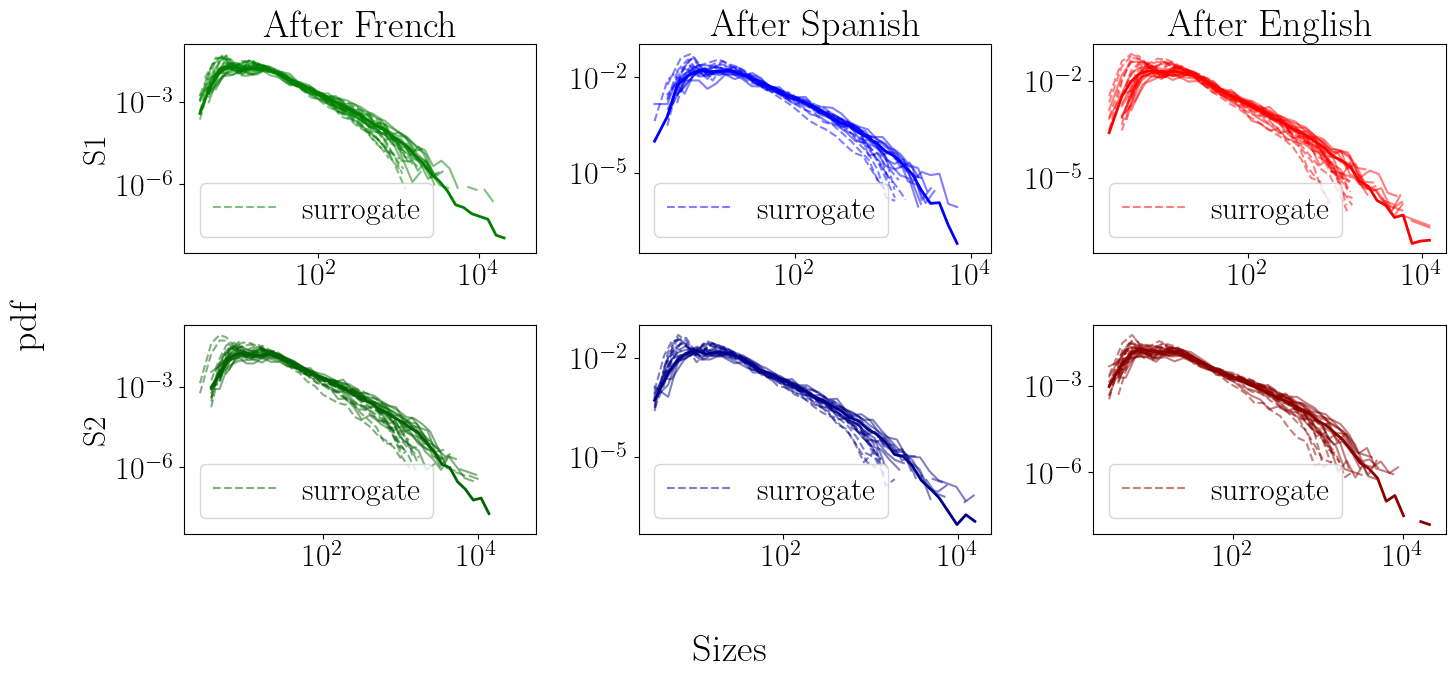

In [27]:
plt.rcParams['text.usetex'] =True
plt.rcParams['font.size'] = 23
plt.rcParams['font.family'] = 'serif',
plt.rcParams['font.serif'] =  'Computer Modern'
fig, ax = plt.subplots(2,3, figsize =(15,7))


kk  = np.asarray([[ss_fren, surrs_fren], [ss_spa, surrs_spa],[ss_eng, surrs_eng]])

cums1 = [[],[],[]]

colors = ['green', 'blue', 'red']
for j in range(3):
#for j in range(2):
    for s in range(len(kk[j,0])):
        try:
            pwl.plot_pdf(kk[j,0][s], color =colors[j],ax=ax[0,j], alpha =.5)
            if s == 0:
                label ='surrogate'
            else: 
                label = None
            pwl.plot_pdf(kk[j,1][s], color =colors[j], ls = '--', ax =ax[0,j], alpha =.5, label =label)

            cums1[j]+=kk[j,0][s]
        except:
            continue


for j in range(3):
    pwl.plot_pdf(cums1[j], color =colors[j],ax =ax[0,j], lw = 2)
    #fit = pwl.Fit(cums1[j], discrete = False, xmax = max(cums1[j]), xmin = (1,100)) #(1,50)

    #alpha = round(fit.power_law.alpha,2)
    #fit.power_law.plot_pdf(color = colors[j], label =r"$\alpha$" + f" = {alpha}",ax =ax[0,j],)
    ax[0,j].legend()
    
cums2 = [[],[],[]]

    

kk  = np.asarray([[ss2_fren, surr2s_fren], [ss2_spa, surr2s_spa],[ss2_eng, surr2s_eng]])
colors = ['darkgreen', 'darkblue', 'darkred']
for j in range(3):
    for s in range(len(kk[j,0])):
    #for j in range(2):
        try:
            pwl.plot_pdf(kk[j,0][s], color =colors[j],ax =ax[1,j], alpha = .5)
            if s == 0:
                label ='surrogate'
            else: 
                label = None
            
            pwl.plot_pdf(kk[j,1][s], color =colors[j], ls = '--', ax=ax[1,j], alpha = .5, label =label)
                
            cums2[j]+=kk[j,0][s]
            
                
        except:
            continue
for j in range(3):
    pwl.plot_pdf(cums2[j], color =colors[j],ax =ax[1,j], lw = 2)
    #fit = pwl.Fit(cums2[j], discrete = False, xmax =  max(cums2[j]), xmin = (1,100)) #(1,50)
    
    #alpha = round(fit.power_law.alpha,2)
    #fit.power_law.plot_pdf(color = colors[j], label =r"$\alpha$ = "+f"{alpha}",ax =ax[1,j])
    ax[1,j].legend()
    
ax[0,0].set_title('After French')
ax[0,0].set_ylabel('S1')
ax[1,0].set_ylabel('S2')


ax[0,1].set_title('After Spanish')
ax[0,2].set_title('After English')

fig.supxlabel('Sizes')
fig.supylabel('pdf')
plt.tight_layout();




C:\Users\Benedetta\AppData\Local\Temp\ipykernel_2456\3722460070.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kk  = np.asarray([[ss_fren, surrs_fren], [ss_spa, surrs_spa],[ss_eng, surrs_eng]])
C:\Users\Benedetta\AppData\Local\Temp\ipykernel_2456\3722460070.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kk  = np.asarray([[ss2_fren, surr2s_fren], [ss2_spa, surr2s_spa],[ss2_eng, surr2s_eng]])


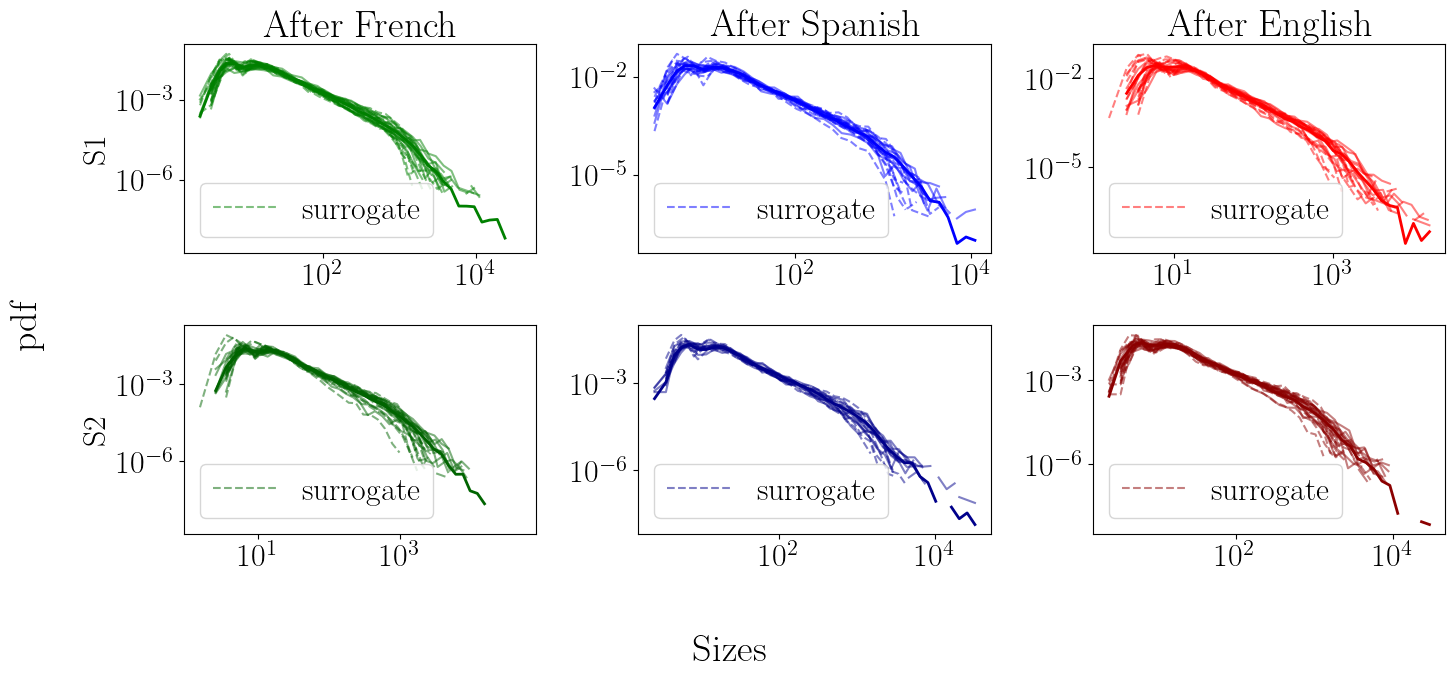

In [22]:
plt.rcParams['text.usetex'] =True
plt.rcParams['font.size'] = 23
plt.rcParams['font.family'] = 'serif',
plt.rcParams['font.serif'] =  'Computer Modern'
fig, ax = plt.subplots(2,3, figsize =(15,7))


kk  = np.asarray([[ss_fren, surrs_fren], [ss_spa, surrs_spa],[ss_eng, surrs_eng]])

cums1 = [[],[],[]]

colors = ['green', 'blue', 'red']
for j in range(3):
#for j in range(2):
    for s in range(len(kk[j,0])):
        try:
            pwl.plot_pdf(kk[j,0][s], color =colors[j],ax=ax[0,j], alpha =.5)
            if s == 0:
                label ='surrogate'
            else: 
                label = None
            pwl.plot_pdf(kk[j,1][s], color =colors[j], ls = '--', ax =ax[0,j], alpha =.5, label =label)

            cums1[j]+=kk[j,0][s]
        except:
            continue


for j in range(3):
    pwl.plot_pdf(cums1[j], color =colors[j],ax =ax[0,j], lw = 2)
    #fit = pwl.Fit(cums1[j], discrete = False, xmax = max(cums1[j]), xmin = (1,100)) #(1,50)

    #alpha = round(fit.power_law.alpha,2)
    #fit.power_law.plot_pdf(color = colors[j], label =r"$\alpha$" + f" = {alpha}",ax =ax[0,j],)
    ax[0,j].legend()
    
cums2 = [[],[],[]]

    

kk  = np.asarray([[ss2_fren, surr2s_fren], [ss2_spa, surr2s_spa],[ss2_eng, surr2s_eng]])
colors = ['darkgreen', 'darkblue', 'darkred']
for j in range(3):
    for s in range(len(kk[j,0])):
    #for j in range(2):
        try:
            pwl.plot_pdf(kk[j,0][s], color =colors[j],ax =ax[1,j], alpha = .5)
            if s == 0:
                label ='surrogate'
            else: 
                label = None
            
            pwl.plot_pdf(kk[j,1][s], color =colors[j], ls = '--', ax=ax[1,j], alpha = .5, label =label)
                
            cums2[j]+=kk[j,0][s]
            
                
        except:
            continue
for j in range(3):
    pwl.plot_pdf(cums2[j], color =colors[j],ax =ax[1,j], lw = 2)
    #fit = pwl.Fit(cums2[j], discrete = False, xmax =  max(cums2[j]), xmin = (1,100)) #(1,50)
    
    #alpha = round(fit.power_law.alpha,2)
    #fit.power_law.plot_pdf(color = colors[j], label =r"$\alpha$ = "+f"{alpha}",ax =ax[1,j])
    ax[1,j].legend()
    
ax[0,0].set_title('After French')
ax[0,0].set_ylabel('S1')
ax[1,0].set_ylabel('S2')


ax[0,1].set_title('After Spanish')
ax[0,2].set_title('After English')

fig.supxlabel('Sizes')
fig.supylabel('pdf')
plt.tight_layout();




In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import powerlaw as pwl

# Avalanche exponents t-tests

In [33]:
175

True

In [40]:
### COMPARISON BETWEEN SILENCE1 AND SILENCE2

import os
import numpy as np
#import scipy.signal as ss
import scipy.io
#from dfa_functions import *

subjs  = [5,6,9,11,12,13,16,17,18,19,21,23,24,25,30,33,34,35,37,39,40,45,47,49,52,53,56,57,58,60,62,63,65,66,67,68,69,71,14,20,22,27,28,29,31,41,46,64,70]
print(len(subjs))
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from scipy.signal import welch
import pandas as pd
import mne


ch_names = ['F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8']
alphas1 = []
taus1 =[]

deltas1 = []
deltas2 = []


alphas2 = []
taus2 =[]



alphas1_surr = []
taus1_surr =[]

deltas1_surr = []
deltas2_surr = []


alphas2_surr = []
taus2_surr =[]
ss =[]
dd =[]
ss2,dd2 =[],[]
#good_sub = []
filterr = True

ch_names = np.array(ch_names)
sfreq = 500
info = mne.create_info(ch_names = list(ch_names),
                       ch_types = 'eeg',
                       sfreq = sfreq)
o = 0
for i, subj in enumerate(subjs):
    print(f'\n\n########## SUBJ {subj} ({i+1}/{len(subjs)})##########')
    s1 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence1 (continuous).mat')
    s2 = loadmat(f'BB{subj}_Filtered (1-100)/Silence (500)/BB{subj} silence2 (continuous).mat')
    data = s1['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    if idx_down > 0 or idx_up < data.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data.shape[1]:
            idx_up -= 1
        data = data[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data = data[list(idx_accepted), idx_down:idx_up]
    nchan = data.shape[0]
    
    data2 = s2['eeg_rest'].astype('float')
    rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    if idx_down > 0 or idx_up < data2.shape[1]:
        if idx_down > 0:
            idx_down +=1
        if idx_up < data2.shape[1]:
            idx_up -= 1
        data2 = data2[:,idx_down:idx_up]
        rej, idx_down, idx_up = find_bad_channels(data2, verbose = False)
    idx_accepted = np.sort([np.where(ch_names == i)[0][0] for i in list(set(ch_names) - set(rej))])
    data2 = data2[list(idx_accepted), idx_down:idx_up]
    nchan2 = data2.shape[0]
    print(nchan, nchan2)
    if nchan >= 5 and nchan2 >=5 and subj != 53:
   
        b,a = signal.butter(2, 50, btype = 'lowpass',fs = 500)

        if filterr:
            dataa = signal.filtfilt(b,a, data, axis = -1)
            dataa2 = signal.filtfilt(b,a, data2, axis = -1)
        else:
            dataa = data
            dataa2 = data2
        
        print('doing')
        s,d = compute_avalanches(dataa.T,fs = 500,theta =2,discretized=False)
        s2,d2 =  compute_avalanches(dataa2.T,fs = 500,theta =2,discretized=False)
        ss.append(s)
        dd.append(d)
        ss2.append(s2)
        dd2.append(d2)
        
            
        v = scaling(s,d*1000, plotto = False)

        deltas1.append(v[2])

        good_sub.append(subj)
        data = s
        fit = pwl.Fit(data,xmin =(1,100),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        alphas1.append(exp)
        
        data = d*1000
        fit = pwl.Fit(data,xmin =(10,20),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        taus1.append(exp)

        data = s2
        fit = pwl.Fit(data,xmin =(1,100),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        alphas2.append(exp)
        
        data = d2*1000
        fit = pwl.Fit(data,xmin =(10,20),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        taus2.append(exp)
        
        
        v = scaling(s2,d2*1000, plotto = False)
        deltas2.append(v[2])
        
        
        
        
        s,d = compute_avalanches(AAFT_surrogates(dataa).T,theta=2, fs = 500,discretized=False)
        s2,d2 = compute_avalanches(AAFT_surrogates(dataa2).T,theta =2, fs =500,discretized=False)
        #ss.append(s)
        #dd.append(d)
        #ss2.append(s2)
        ##dd2.append(d2)
        
        """
        v = scaling(s,d*0.002, plotto = False)

        deltas1_surr.append(v[2])

        #good_sub.append(subj)
        data = s
        fit = pwl.Fit(data,xmin =(1,100),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        alphas1_surr.append(exp)
        
        data = d*0.002
        fit = pwl.Fit(data,xmin =(0,0.05),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        taus1_surr.append(exp)

        data = s2
        fit = pwl.Fit(data,xmin =(1,100),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        alphas2_surr.append(exp)
        
        data = d2*0.002
        fit = pwl.Fit(data,xmin =(0,0.05),xmax= max(data),parameter_range= {"alpha":[1,4]},discrete = False)
        exp = fit.power_law.alpha
        taus2_surr.append(exp)
        
        
        v = scaling(s2,d2*0.002, plotto = False)
        deltas2_surr.append(v[2])
        """
        

        o += 1
        

49


########## SUBJ 5 (1/49)##########
7 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1393355567772372 +- 0.015474600733801658
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1465212113567973 +- 0.012264462056445253


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 6 (2/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1278549910321898 +- 0.011691613774411734
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1286208745167352 +- 0.012446672603939519


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 9 (3/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0766564948829362 +- 0.010365990188637654
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1262556508008612 +- 0.011520647921896459


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 11 (4/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0947038138862866 +- 0.011568359941842124
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.120537933794656 +- 0.012016876936953034


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 12 (5/49)##########
10 7
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1441576314855306 +- 0.011838545990015315
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1267107205435036 +- 0.014440983613130938


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 13 (6/49)##########
0 8


########## SUBJ 16 (7/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1319204051212588 +- 0.009990643696370581
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.14557799182601 +- 0.010828112688623607


########## SUBJ 17 (8/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.133133707462331 +- 0.011149582068893734
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1462341464169539 +- 0.011898733262850696


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 18 (9/49)##########
8 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1044186014381783 +- 0.011730657965840535
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1283314967932512 +- 0.01108059663410782


########## SUBJ 19 (10/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.148544274968031 +- 0.011177001319570105
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1243716166860123 +- 0.010768374516927179


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 21 (11/49)##########
9 1


########## SUBJ 23 (12/49)##########
8 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0881000292528946 +- 0.014600876118666107
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1343402410842023 +- 0.011449829546699852


########## SUBJ 24 (13/49)##########
0 10


########## SUBJ 25 (14/49)##########
2 10


########## SUBJ 30 (15/49)##########
10 8
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1194793471343523 +- 0.01214441130219896
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1414573015544973 +- 0.011779014065368212


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 33 (16/49)##########
7 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0870427584870614 +- 0.011240479735557543
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1092983828111795 +- 0.010186524197343083


########## SUBJ 34 (17/49)##########
0 10


########## SUBJ 35 (18/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0879551760904524 +- 0.01071816951515283
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1449519299318767 +- 0.01005350591855374


########## SUBJ 37 (19/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0847475961712225 +- 0.013308668288035435
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.132804608014871 +- 0.011814292174191419


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 39 (20/49)##########
4 9


########## SUBJ 40 (21/49)##########
6 8
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0894821196023585 +- 0.010971443032782897
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.146210294820484 +- 0.01101474608928211


########## SUBJ 45 (22/49)##########
9 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1092791837239062 +- 0.014622077375730146
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.135006704689854 +- 0.011192541938354218


########## SUBJ 47 (23/49)##########
9 7
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1227323428382003 +- 0.011239608161856606
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1334072116414717 +- 0.016576806029091513


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 49 (24/49)##########
10 8
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1107996228357253 +- 0.01181441029519594


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0957514652979317 +- 0.011970468949594101


########## SUBJ 52 (25/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1703453419693484 +- 0.022014433679459468
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1485758875617909 +- 0.011395064495062402


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 53 (26/49)##########
5 9


########## SUBJ 56 (27/49)##########
10 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1123462523056005 +- 0.01069384578863444
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1559518738834411 +- 0.011658896645814988


########## SUBJ 57 (28/49)##########
2 10


########## SUBJ 58 (29/49)##########
10 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.130727611663294 +- 0.013211918722045706
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1187358764200555 +- 0.010013724539863272


########## SUBJ 60 (30/49)##########
10 0


########## SUBJ 62 (31/49)##########
7 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1387611086910339 +- 0.014552472127921814
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1387919537803184 +- 0.014855897413400978


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 63 (32/49)##########
1 10


########## SUBJ 65 (33/49)##########
0 9


########## SUBJ 66 (34/49)##########
10 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1113492390176614 +- 0.0148987227430991
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1157222539396325 +- 0.01364400189484006


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 67 (35/49)##########
10 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.138471035963378 +- 0.013110915671371225
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1112899175127318 +- 0.010934443013240206


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 68 (36/49)##########
8 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1239663774326154 +- 0.01215142978258677
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1431679441095315 +- 0.012833676659202885


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 69 (37/49)##########
3 10


########## SUBJ 71 (38/49)##########
6 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1601367128991158 +- 0.018533875777352236
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1446456873384439 +- 0.013727759030680551


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 14 (39/49)##########
5 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0608754319810272 +- 0.010918664470215915
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1258493984261737 +- 0.01064900945570947


########## SUBJ 20 (40/49)##########
0 10


########## SUBJ 22 (41/49)##########
8 8
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0531412374596143 +- 0.00945182749246599
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.0845202888908594 +- 0.011484690258485045


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 27 (42/49)##########
7 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1255829892075553 +- 0.011761899272472625
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1320609263723929 +- 0.009849455075036966


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 28 (43/49)##########
3 10


########## SUBJ 29 (44/49)##########
4 4


########## SUBJ 31 (45/49)##########
4 8


########## SUBJ 41 (46/49)##########
10 9
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1408902303579092 +- 0.012369695962364301
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1413445163202351 +- 0.01009114269125942


########## SUBJ 46 (47/49)##########
8 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1418078642937983 +- 0.02189039724476534
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1101734845461566 +- 0.010951922953858438


########## SUBJ 64 (48/49)##########
9 10
doing
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1308734127323974 +- 0.010839572876341942
Calculating best minimal value for power law fit


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Prediction from crackling noise relation: delta =  nan +- nan
Fit from of average size given duration points: delta =  1.1377206374447912 +- 0.011801472377115407


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan




########## SUBJ 70 (49/49)##########
0 3


In [38]:
50*1e-3

0.05

Calculating best minimal value for power law fit


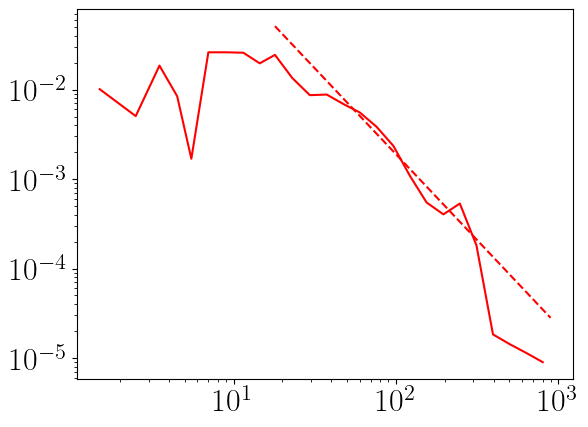

In [39]:
fit = pwl.Fit(dd[15]*1000, discrete = False,xmax =max(dd[15]*1000), xmin=(10,20))
fit.power_law.plot_pdf(color ='red', linestyle ='--')
pwl.plot_pdf(dd[15]*1000, color ='red');

Calculating best minimal value for power law fit


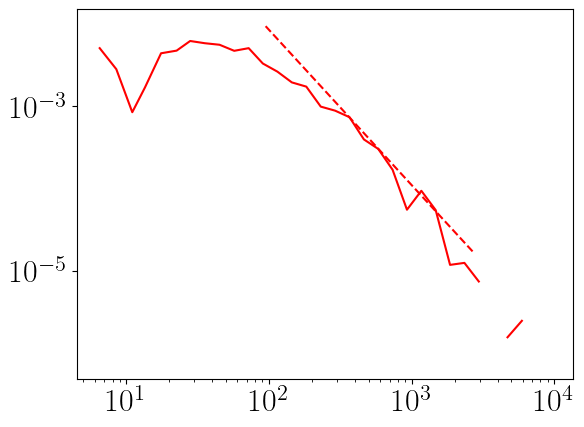

In [33]:
fit = pwl.Fit(ss[15], discrete = False,xmax =max(ss[15]), xmin = (1,100), )
fit.power_law.plot_pdf(color ='red', linestyle ='--')
pwl.plot_pdf(ss[15], color ='red');

Calculating best minimal value for power law fit


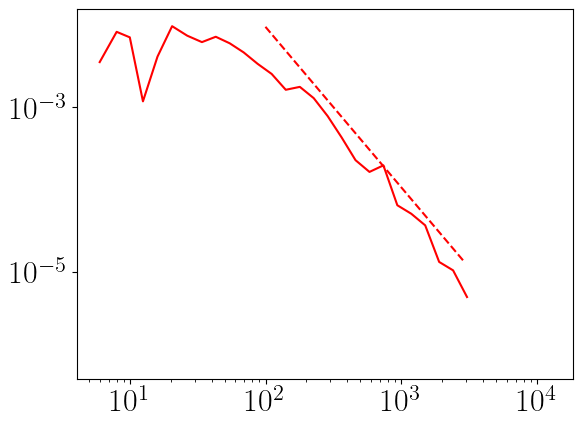

In [24]:
fit = pwl.Fit(ss[16], discrete = False,xmax =max(ss[0]), xmin = (1,100), )
fit.power_law.plot_pdf(color ='red', linestyle ='--')
pwl.plot_pdf(ss[16], color ='red');

Calculating best minimal value for power law fit


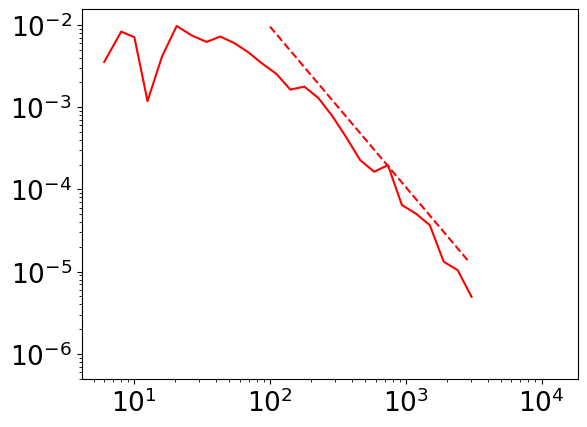

In [77]:
fit = pwl.Fit(ss[16], discrete = False,xmax =max(ss[0]), xmin = (1,100), )
fit.power_law.plot_pdf(color ='red', linestyle ='--')
pwl.plot_pdf(ss[16], color ='red');

In [55]:
good_sub = np.array([ 5,  6,  9, 11, 12, 16, 17, 18, 19, 23, 30, 33, 35, 37, 40, 45, 47,
       49, 52, 56, 58, 62, 66, 67, 68, 71, 14, 22, 27, 41, 46, 64])

In [45]:
### ORDER OF THE LANGUAGES
order = pd.read_excel('../../../Downloads/ordine lingue.xlsx')#1 en, 2 fr, 3 sp

In [46]:

subject_french = order[order["last language"]==2]["subject"].values

subject_en = order[order["last language"]==1]["subject"].values

subject_span = order[order["last language"]==3]["subject"].values

In [47]:
sub_fren = (list(set(subject_french) & set(good_sub)))
sub_span = (list(set(subject_span) & set(good_sub)))
sub_en = (list(set(subject_en) & set(good_sub)))


In [54]:
list(map(len, [sub_fren, sub_span, sub_en]))

[12, 9, 11]

In [56]:
good_sub = np.asarray(good_sub)
alphas1 = np.asarray(alphas1)
alphas2 = np.asarray(alphas2)
taus1 = np.asarray(taus1)
taus2 = np.asarray(taus2)
deltas1 = np.asarray(deltas1)
deltas2 = np.asarray(deltas2)
#index. = np.where()

In [57]:
good_sub = np.asarray(good_sub)
alphas1_surr = np.asarray(alphas1_surr)
alphas2_surr = np.asarray(alphas2_surr)
taus1_surr = np.asarray(taus1_surr)
taus2_surr = np.asarray(taus2_surr)
deltas1_surr = np.asarray(deltas1_surr)
deltas2_surr = np.asarray(deltas2_surr)
#index. = np.where()

In [43]:
h = []
for k in sub_fren:
    #if k in good_sub:
    #h.append(np.where(k == good_sub)[0])
    h.append(good_sub.tolist().index(k))
print(h)        
#np.concatenate(h)

[28, 29, 19, 2, 63, 3, 4, 22, 5, 13, 33, 25]


In [56]:
ll = np.concatenate([np.where(good_sub==i)[0] for i in sub_fren])

In [52]:
def funct2(sub, vec1):
    index = np.concatenate([np.where(good_sub==i)[0] for i in sub])
    #index = np.where(good_sub, sub_fren)
    al1 = vec1[index]
    #al2 = vec2[index]
    return al1
    #print(stats.

In [53]:
import scipy.stats as stats 

def funct(sub, vec1, vec2, option ='greater'):
    index = np.concatenate([np.where(good_sub==i)[0] for i in sub])
    #index = np.where(good_sub, sub_fren)
    al1 = vec1[index]
    al2 = vec2[index]
    print(stats.ttest_rel(al1, al2,alternative = option) )
    

In [51]:
len(alphas1)

32

In [58]:
funct2(sub_fren, alphas1).mean(),funct2(sub_fren, alphas2).mean()

(1.8811409511623463, 1.8340026356961037)

In [59]:
funct2(sub_fren, alphas1).mean(),funct2(sub_fren, alphas2).mean()

(1.8811409511623463, 1.8340026356961037)

In [60]:
funct(sub_fren,alphas1_surr,alphas2_surr)
funct(sub_en,alphas1_surr,alphas2_surr)
funct(sub_span,alphas1_surr,alphas2_surr)

IndexError: index 22 is out of bounds for axis 0 with size 0

In [61]:
funct(sub_fren,alphas1,alphas2) ## FRENCH IS SIGNIFICANT
funct(sub_en,alphas1,alphas2)
funct(sub_span,alphas1,alphas2)

TtestResult(statistic=1.3777125045795462, pvalue=0.09783716801228601, df=11)
TtestResult(statistic=0.6823373058012522, pvalue=0.25526069291276055, df=10)
TtestResult(statistic=0.5530267026631586, pvalue=0.2976783422460515, df=8)


In [62]:
funct(sub_fren,taus1,taus2)
funct(sub_en,taus1,taus2)
funct(sub_span,taus1,taus2)

TtestResult(statistic=2.4384596571374884, pvalue=0.016456236050573298, df=11)
TtestResult(statistic=-0.7672534347572963, pvalue=0.7696689918708033, df=10)
TtestResult(statistic=0.47917087616593185, pvalue=0.32232054163902346, df=8)


In [36]:
len(alphas1)

32

In [63]:
funct(sub_fren,deltas1,deltas2, 'less') # FRENCH IS SIGNIFICANTE
funct(sub_en,deltas1,deltas2, 'less')
funct(sub_span,deltas1,deltas2, 'less')

TtestResult(statistic=-2.422126679578291, pvalue=0.016939509288611865, df=11)
TtestResult(statistic=-1.356032081779882, pvalue=0.10245846852888373, df=10)
TtestResult(statistic=-1.1220743389996204, pvalue=0.14718849652939475, df=8)


In [64]:
# Importing library 
import scipy.stats as stats 

stats.ttest_rel(alphas1, alphas2,alternative = 'greater') 


TtestResult(statistic=1.526059832873198, pvalue=0.0685670393201223, df=31)

In [65]:
# Importing library 
import scipy.stats as stats 


stats.ttest_rel(deltas1, deltas2,alternative = 'less') 

TtestResult(statistic=-2.878713675631491, pvalue=0.003586863422049976, df=31)

In [66]:
# Importing library 
import scipy.stats as stats 
)

stats.ttest_rel(taus1, taus2,alternative = 'greater') 

TtestResult(statistic=1.2571582185414638, pvalue=0.10904289875124906, df=31)

In [38]:
# Importing library 
import scipy.stats as stats 


stats.ttest_rel(taus1, taus2,) 

TtestResult(statistic=-1.015727777328112, pvalue=0.3173776932365956, df=32)

In [31]:
stats.ttest_rel(deltas1, deltas2,alternative = 'less') 

TtestResult(statistic=-2.6655888161610273, pvalue=0.005972661835473558, df=32)

In [39]:
plt.rcParams['font.size'] = 17

In [67]:
a_frenc1 = funct2(sub_fren, np.asarray(alphas1))
a_frenc2 = funct2(sub_fren, np.asarray(alphas2))

a_span1 = funct2(sub_span, np.asarray(alphas1))
a_span2 = funct2(sub_span, np.asarray(alphas2))

a_eng1 = funct2(sub_en, np.asarray(alphas1))
a_eng2 = funct2(sub_en, np.asarray(alphas2))

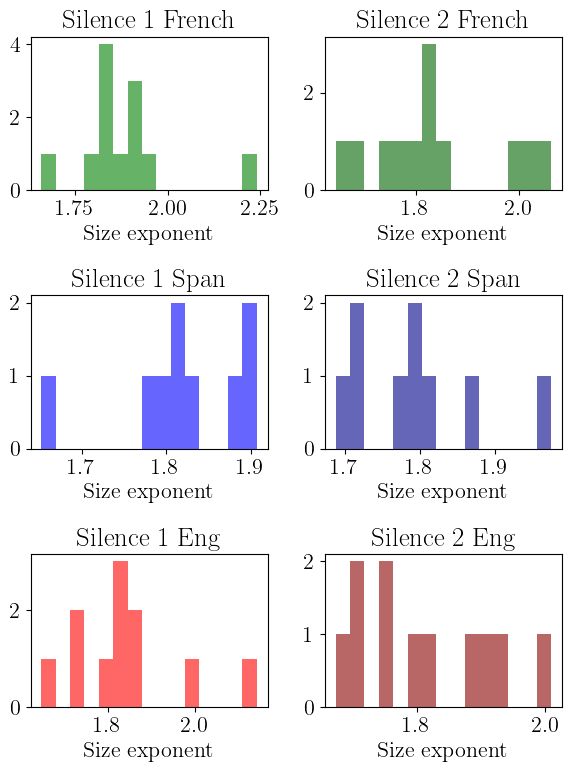

In [68]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize = (6,8))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)


ax1.hist(a_frenc1, color = 'green', alpha = .6, bins = 15)
ax2.hist(a_frenc2, color = 'darkgreen', alpha = .6, bins = 15)
ax1.set_title('Silence 1 French')
ax2.set_title('Silence 2 French')

ax1.set_xlabel('Size exponent')
ax2.set_xlabel('Size exponent')

ax3.hist(a_span1, color = 'blue', alpha = .6, bins = 15)
ax4.hist(a_span2, color = 'darkblue', alpha = .6, bins = 15)
ax3.set_title('Silence 1 Span')
ax4.set_title('Silence 2 Span')

ax3.set_xlabel('Size exponent')
ax4.set_xlabel('Size exponent')

ax5.hist(a_eng1, color = 'red', alpha = .6, bins = 15)
ax6.hist(a_eng2, color = 'darkred', alpha = .6, bins = 15)
ax5.set_title('Silence 1 Eng')
ax6.set_title('Silence 2 Eng')

ax5.set_xlabel('Size exponent')
ax6.set_xlabel('Size exponent')
plt.tight_layout();

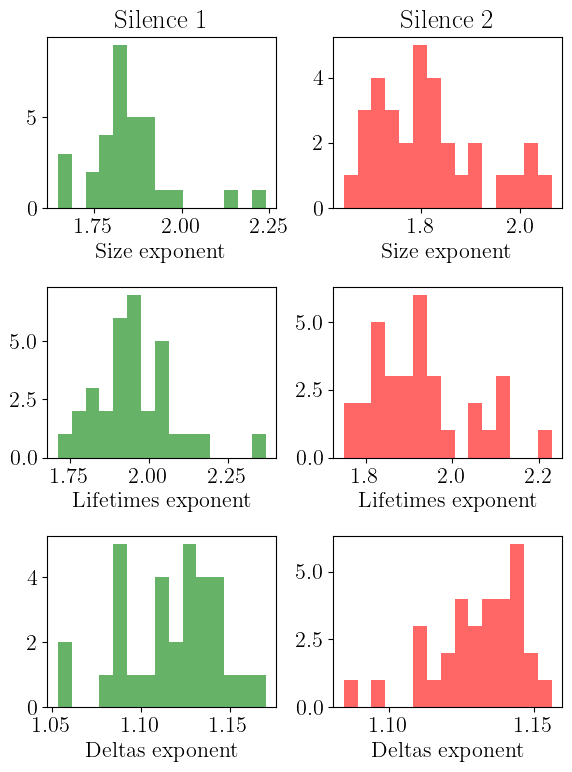

In [69]:
fig = plt.figure(figsize = (6,8))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)


ax1.hist(alphas1, color = 'green', alpha = .6, bins = 15)
ax2.hist(alphas2, color = 'red', alpha = .6, bins = 15)
ax1.set_title('Silence 1')
ax2.set_title('Silence 2')

ax1.set_xlabel('Size exponent')
ax2.set_xlabel('Size exponent')


#ax3.set_title('Silence 1')
#ax4.set_title('Silence 2')
ax3.hist(taus1, color = 'green', alpha = .6, bins = 15)
ax4.hist(taus2, color = 'red', alpha = .6, bins = 15)
ax3.set_xlabel('Lifetimes exponent')
ax4.set_xlabel('Lifetimes exponent')


#ax5.set_title('Silence 1')
#ax6.set_title('Silence 2')
ax5.hist(deltas1, color = 'green', alpha = .6, bins = 15)
ax6.hist(deltas2, color = 'red', alpha = .6, bins = 15)
ax5.set_xlabel('Deltas exponent');
ax6.set_xlabel('Deltas exponent');
plt.tight_layout();
